[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.000000

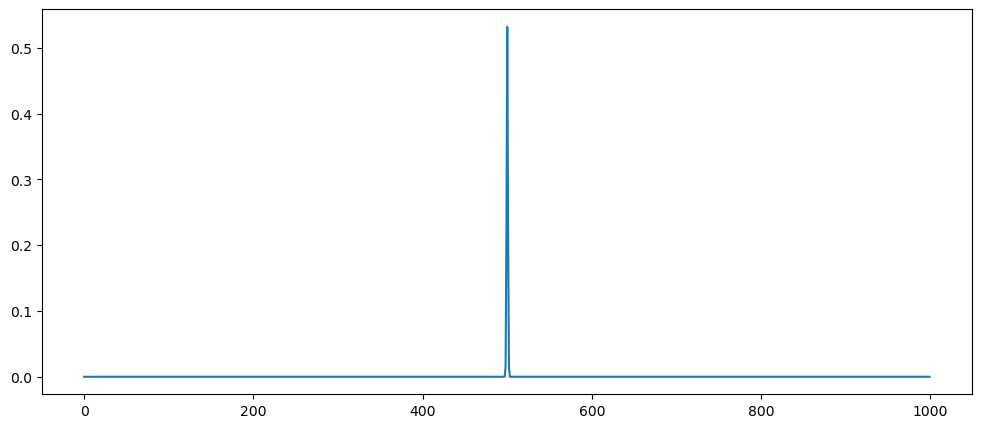

Parquet columns: Index(['Branches', 'Country', 'Month', 'Unit', 'DATA'], dtype='object')

Exports (Sweden, Whole fish) sample:
Unit    Country                                 Branches       date  \
1310640  Sweden  00 Whole fish, fresh, chilled or on ice 2015-01-01   
1310641  Sweden  00 Whole fish, fresh, chilled or on ice 2015-02-01   
1310642  Sweden  00 Whole fish, fresh, chilled or on ice 2015-03-01   
1310643  Sweden  00 Whole fish, fresh, chilled or on ice 2015-04-01   
1310644  Sweden  00 Whole fish, fresh, chilled or on ice 2015-05-01   

Unit     fob_value   tonnes  
1310640    24.5692   61.541  
1310641    23.7582   61.397  
1310642    48.4907  125.518  
1310643    22.6574   60.240  
1310644    46.9166  124.095  

Merged series head (fob, tonnes, cpi, fx):
        date  fob_value   tonnes  cpi_index      usd_fx
0 2015-01-01    24.5692   61.541      419.3  131.568095
1 2015-02-01    23.7582   61.397      422.1  132.026500
2 2015-03-01    48.4907  125.518      426.4  136.82409

/var/folders/bx/p7rxw7nx4x3cbgmqc7ym7gsm0000gn/T/ipykernel_72536/604236722.py:239: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  toClasses = lambda x: int(scale*(x - mint) + base)
/opt/anaconda3/envs/tf312/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/120
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - loss: nan - val_loss: nan
Epoch 2/120
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - loss: nan - val_loss: nan
Epoch 3/120
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - loss: nan - val_loss: nan
Epoch 4/120
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - loss: nan - val_loss: nan
Epoch 5/120
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 169ms/step - loss: nan - val_loss: nan
Epoch 6/120
 5/92 ━━━━━━━━━━━━━━━━━━━━ 16s 192ms/step - loss: nan

KeyboardInterrupt: 

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd 

NUMCLASSES = 1000
RANGEMULT = 2
UNCERTAINITY = 0.0015

dev = (NUMCLASSES/RANGEMULT)*UNCERTAINITY
vec = np.linspace(0, NUMCLASSES, NUMCLASSES, endpoint=False)
def uncertainify(tc):
  return stats.norm.pdf(vec, tc, dev)
#vec = stats.norm.pdf(vec, 500, 1)
target_uncertain_vector = np.array(list(map(uncertainify, [500, 200])))
print(target_uncertain_vector[0])
plt.figure(figsize=(12,5))
plt.plot(target_uncertain_vector[0])
plt.show()


In [ ]:

#Simple test code for a LSTM network using two data files in two runs:
#First file:  data1.txt (90 months 2018-2025 total export of services to 250 countries in FOB/MISK)
#Second file: data2.txt.(90 months 2018-2025 total export of goods to USA in Tonnes)

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.nn import softmax
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


#------------(HYPER)PARAMETERS-------------
LOOKBACK = 12
NUMCLASSES = 2000
RANGEMULT = 2
UNCERTAINITY = 0.0025
UNCERTAINIFY = True #Enable or disable uncertifying.

EPOCHS = 120
BATCH_SIZE = 1

ALPHA = 0.1

PARQUET_FILE  = "Exports-by-branches-of-processing-and-countries-2015-2025.parquet"
CPI_FILE      = "Inflation-Consumer price index.csv"
FX_FILE       = "Exchange-rates_2015-2025.csv"

TARGET_COUNTRY = "Sweden"
TARGET_BRANCH  = "00 Whole fish, fresh, chilled or on ice"
# -----------Initialation and READ DATA Two different Real dataset are used:-------------------
# data1= Total sales of services MISK last 90 months,
# data3= Export of goods to USA in Tonnes last 90 months
# ---------------------------------------------------------------------------------------------
np.random.seed(42)
months = 90
t = np.arange(months)
numbers_list = []
numbers_list3 = []

# -------------------------
# Sequence maker function
# -------------------------
def make_sequences(X, y, yu, y_class, LOOKBACK):
    Xs, yus, ys, ycs = [], [], [], []
    for i in range(len(X) - LOOKBACK):
        #print(i,"\t", X[i:i+LOOKBACK])             # Commented out print statement
        Xs.append(X[i:i+LOOKBACK])
        yus.append(y[i+LOOKBACK])
        ys.append(y[i+LOOKBACK])
        ycs.append(y_class[i+LOOKBACK])
    return np.array(Xs), np.array(yus), np.array(ys), np.array(ycs)

# ------------------------------------------------------
# Calculates: Weighted Absolute Percentage Error (WAPE).
# Returns: The WAPE value as a float. Returns 0 if the
# sum of actual values is zero.
# ------------------------------------------------------
def calculate_wape(y_true, y_pred):
  y_true = np.array(y_true)                         # y_true: A numpy array or list of actual values.
  y_pred = np.array(y_pred)                         # y_pred: A numpy array or list of predicted values.

  # Avoid division by zero
  if np.sum(np.abs(y_true)) == 0:
    return 0
  else:
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

# ---------------- DATA LOADING ----------------
def load_exports():
    df = pd.read_parquet(PARQUET_FILE)
    print("Parquet columns:", df.columns)

    # Clean
    df["Country"] = (
        df["Country"].astype(str)
        .str.replace("\xa0", " ", regex=False)
        .str.strip()
    )
    df["Branches"] = df["Branches"].astype(str).str.strip()

    df["date"] = pd.to_datetime(
        df["Month"].astype(str).str.replace("M", "-") + "-01",
        errors="coerce"
    )
    df = df.dropna(subset=["date"])

    # Keep only Fob value + Tonnes
    df = df[df["Unit"].isin(["Fob value", "Tonnes"])].copy()
    df["DATA"] = pd.to_numeric(df["DATA"], errors="coerce")
    df = df.dropna(subset=["DATA"])

    # Pivot to columns
    df_piv = df.pivot_table(
        index=["Country", "Branches", "date"],
        columns="Unit",
        values="DATA",
        aggfunc="sum"
    ).reset_index()

    df_piv = df_piv.rename(columns={"Fob value": "fob_value", "Tonnes": "tonnes"})
    df_piv["fob_value"] = df_piv["fob_value"].fillna(0.0)
    df_piv["tonnes"]    = df_piv["tonnes"].fillna(0.0)

    # Filter target series
    mask = (
        (df_piv["Country"] == TARGET_COUNTRY) &
        (df_piv["Branches"] == TARGET_BRANCH)
    )
    series = df_piv[mask].sort_values("date")

    if series.empty:
        raise ValueError(f"No data for {TARGET_COUNTRY} - {TARGET_BRANCH}")

    print("\nExports (Sweden, Whole fish) sample:")
    print(series.head())

    return series[["date", "fob_value", "tonnes"]].reset_index(drop=True)

def load_cpi():
    cpi = pd.read_csv(CPI_FILE)
    cpi["date"] = pd.to_datetime(
        cpi["Month"].astype(str).str.replace("M", "-") + "-01",
        errors="coerce"
    )
    cpi["cpi_index"] = pd.to_numeric(
        cpi["Consumer price index Index"], errors="coerce"
    )
    cpi = cpi.dropna(subset=["date", "cpi_index"])
    return cpi[["date", "cpi_index"]].sort_values("date").reset_index(drop=True)

def load_fx():
    fx = pd.read_csv(FX_FILE, sep=";", engine="python")
    date_col = fx.columns[0]
    fx[date_col] = pd.to_datetime(fx[date_col], errors="coerce", dayfirst=True)

    usd_cols = [c for c in fx.columns if "Bandaríkjadalur" in c and "miðgengi" in c]
    if not usd_cols:
        raise ValueError("USD mid column not found in FX file.")
    usd_col = usd_cols[0]

    fx["usd_fx"] = (
        fx[usd_col]
        .astype(str)
        .str.replace(".", "", regex=False)
        .str.replace(",", ".", regex=False)
    )
    fx["usd_fx"] = pd.to_numeric(fx["usd_fx"], errors="coerce")

    fx = fx.dropna(subset=[date_col, "usd_fx"])
    fx["year_month"] = fx[date_col].dt.to_period("M")
    fx_monthly = fx.groupby("year_month", as_index=False)["usd_fx"].mean()
    fx_monthly["date"] = fx_monthly["year_month"].dt.to_timestamp()
    return fx_monthly[["date", "usd_fx"]].sort_values("date").reset_index(drop=True)

def load_merged_series():
    exp_df = load_exports()
    cpi_df = load_cpi()
    fx_df  = load_fx()

    merged = (
        exp_df
        .merge(cpi_df, on="date", how="inner")
        .merge(fx_df,  on="date", how="inner")
        .sort_values("date")
        .reset_index(drop=True)
    )

    print("\nMerged series head (fob, tonnes, cpi, fx):")
    print(merged.head())
    print("Total months after merge:", len(merged))
    return merged

# ----------------------------------------------
# Custom loss function:
# ----------------------------------------------
class UncategoricalCrossEntropyLoss(tf.keras.losses.Loss):
  def __init__(self, name="uncategorical_cross_entropy_loss"):
    super().__init__(name=name)

  def call(self, y_true, y_pred):
    yae = tf.abs(y_true-y_pred)
    #loss = yae
    loss = -tf.math.log(1-yae)
    #loss = -y_true*tf.math.log(y_pred)
    return tf.reduce_sum(loss)


def main():
  # 1) Load merged multifeature series for Sweden / branch
  merged = load_merged_series()
  # merged columns: date, fob_value, tonnes, cpi_index, usd_fx

  # 2) Build features: [fob, tonnes, cpi, fx]
  fob     = merged["fob_value"].values.astype(float)
  tonnes  = merged["tonnes"].values.astype(float)
  cpi     = merged["cpi_index"].values.astype(float)
  usd_fx  = merged["usd_fx"].values.astype(float)

  # Shape: (T, 4)
  features = np.stack([fob, tonnes, cpi, usd_fx], axis=1)

  # Target we're predicting = FOB value
  targets = fob.reshape(-1, 1)

  # 3) Normalize features (per feature)
  f_mean = features.mean(axis=0)
  f_std  = features.std(axis=0)
  f_std[f_std == 0] = 1.0
  features_n = (features - f_mean) / f_std

  # 4) Discretize FOB target into NUMCLASSES (same logic as before)
  targets_1d = targets.ravel()
  mint = targets_1d.min()
  maxt = targets_1d.max()
  rng  = (maxt - mint)

  if rng == 0:
    raise ValueError("FOB series is constant; cannot discretize into classes.")

  scale   = (NUMCLASSES / (RANGEMULT * rng))
  descale = (RANGEMULT * rng) / NUMCLASSES
  base    = NUMCLASSES * ((RANGEMULT - 1) / (2 * RANGEMULT))

  def toClasses(x):
    return int(scale * (x - mint) + base)

  def fromClasses(y):
    return mint + descale * (y - base)

  target_classes = np.array([toClasses(x) for x in targets_1d])

  # 5) Uncertainify / certainify class targets
  dev = (NUMCLASSES / RANGEMULT) * UNCERTAINITY

  def certainify(tc):
    vec = np.zeros(NUMCLASSES)
    vec[tc] = 1.0
    return vec

  vec = np.linspace(0, NUMCLASSES, NUMCLASSES, endpoint=False)

  def uncertainify(tc):
    return stats.norm.pdf(vec, tc, dev)

  target_uncertain_vector = np.array(
      [uncertainify(tc) for tc in target_classes]
  )
  target_certain_vector = np.array(
      [certainify(tc) for tc in target_classes]
  )

  # 6) Build sequences for LSTM (multi-feature input, class-distribution output)
  X, yu, y, y_class = make_sequences(
      features_n,
      target_uncertain_vector,
      target_certain_vector,
      target_classes,
      LOOKBACK
  )

  from sklearn.model_selection import train_test_split
  X_train, X_val, yu_train, yu_val, y_train, y_val, y_train_class, y_val_class = train_test_split(
      X, yu, y, y_class, test_size=0.2, shuffle=False
  )

  if not UNCERTAINIFY:
    # If you want "hard" one-hot targets instead of Gaussian ones
    yu_train = y_train

  # 7) Model (same classification architecture as before)
  model = Sequential()
  model.add(LSTM(NUMCLASSES, input_shape=(LOOKBACK, X.shape[2])))
  model.add(Dense(NUMCLASSES, activation='relu'))
  model.add(Dense(NUMCLASSES, activation='softmax'))

  loss = UncategoricalCrossEntropyLoss()
  model.compile(optimizer='adam', loss=loss)

  # 8) Train
  history = model.fit(
      X_train,
      yu_train,
      validation_data=(X_val, y_val),
      epochs=EPOCHS,
      batch_size=BATCH_SIZE,
      verbose=1
  )

  # 9) Predictions -> continuous FOB via classes
  y_hat = model.predict(X_val, verbose=0)

  # True FOB on validation (continuous)
  y_true = np.array([fromClasses(c) for c in y_val_class])

  # Most likely class -> FOB
  y_pred_mode = []
  for yp in y_hat:
    cls = np.argmax(yp)
    y_pred_mode.append(fromClasses(cls))

  # Expected FOB (probability-weighted over classes)
  y_exp = []
  class_indices = np.arange(NUMCLASSES)
  for yp in y_hat:
    exp_class = np.sum(yp * class_indices)
    y_exp_val = fromClasses(exp_class)
    y_exp.append(y_exp_val)

  # Lower & upper bounds from class distribution (ALPHA)
  y_low = []
  for yp in y_hat:
    prob_running = 0.0
    l = yp.shape[0]
    for c in range(l):
      prob_running += yp[c]
      if prob_running > ALPHA / 2:
        y_low.append(fromClasses(c))
        break

  y_high = []
  for yp in y_hat:
    prob_running = 0.0
    l = yp.shape[0]
    for c in range(l - 1, -1, -1):
      prob_running += yp[c]
      if prob_running > ALPHA / 2:
        y_high.append(fromClasses(c))
        break

  # 10) Plot (now this is FOB for Sweden fish, not "goods to USA")
  plt.figure(figsize=(12, 5))
  plt.plot(y_true, label="Actual FOB")
  plt.plot(y_pred_mode, label="Predicted FOB (most likely class)")
  plt.plot(y_exp, label="Expected FOB (expectation over classes)")
  plt.plot(y_low,  label=f"Lower bound (α/2={ALPHA/2:.3f})")
  plt.plot(y_high, label=f"Upper bound (α/2={ALPHA/2:.3f})")
  plt.title("FOB exports – classification LSTM with FX, CPI, Tonnes, FOB features")
  plt.xlabel("Validation time steps")
  plt.ylabel("FOB value")
  plt.legend()
  plt.tight_layout()
  plt.show()

  # 11) Metrics on expected FOB
  r2 = r2_score(y_true, y_exp)
  wape = calculate_wape(y_true, y_exp)
  accuracy = 100 - wape

  print(f"R-squared on the validation set: {r2:.4f}")
  print(f"Weighted Absolute Percentage Error (WAPE): {wape:.4f}")
  print(f"The model explains {r2*100:.2f}% of variance, "
        f"average error (WAPE) {wape:.2f}% → approx accuracy {accuracy:.2f}%")
  print("Number of merged months used:", len(fob))

  # Return stuff you might want in a second cell
  return target_classes, model, X_train, y_val, y_exp, targets


if __name__== "__main__":
  target_classes, model, X_train, y_val, y_exp, targets = main()


In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# Plot future predictions using only sales data
# ---------------------------------------------------
def plotting(validation_months_indices,future_months_indices_sales_only, future_predictions_sales_only, targets, y_val, y_pred, y_std, y_mean ):
  try:
    plt.figure(figsize=(15, 6))
    plt.plot(np.arange(len(targets)), targets, label="Actual Sales (Historical)")
    plt.plot(validation_months_indices, y_val * y_std + y_mean, label="Actual Sales (Validation)")
    plt.plot(validation_months_indices, y_pred, label="Predicted Sales (Validation - Original Model)")                # Using y_pred from the first cell
    plt.plot(future_months_indices_sales_only, future_predictions_sales_only, label="Predicted Sales (Future - Sales Only)", linestyle='--')
    plt.title("Sales of export Services, Prediction and Future (Sales Only Input)")
    plt.xlabel("Months")
    plt.ylabel("Sales (MISK)")
    plt.legend()
    plt.show()
  except Exception as e:
    print(f"Error in plotting: {e}")

# -------------------------------------------------------
# Predict future sales using only historical sales data
# -------------------------------------------------------
def main(targets_n, y_std, y_mean, model, X_train, y_val, y_pred, targets):                                           # Call the main function from the previous cell to get the variables
                                                                                                                      # The variables are now passed as arguments to this main function
  last_sales_sequence_n = targets_n[-lookback:]                                                                       # Get the last 'lookback' data points from the normalized historical sales data
  future_predictions_sales_only_n = []                                                                                # List to store future normalized predictions
  num_future_months = 24
  try:                                                                                                                # Number of months to predict into the future
    current_sales_sequence_n = last_sales_sequence_n.copy()                                                           # Initialize the current sequence for prediction
    for i in range(num_future_months):                                                                                # Reshape the current sequence to match the model's input shape (1, lookback, num_features)
      input_sequence = current_sales_sequence_n.reshape(1, lookback, 1)                                               # Since we only have one feature (sales or goods), the shape is (1, lookback, 1)
      next_sales_n = model.predict(input_sequence, verbose=0)                                                         # Predict the next sales value (normalized). verbose=0 to reduce output during prediction
      future_predictions_sales_only_n.append(next_sales_n[0, 0])                                                      # Append the predicted sales to the future predictions list
      current_sales_sequence_n = np.roll(current_sales_sequence_n, -1)                                                # Update the current sequence by removing the first value and adding the predicted value
      current_sales_sequence_n[-1] = next_sales_n[0, 0]
    future_predictions_sales_only = np.array(future_predictions_sales_only_n) * y_std + y_mean                        # Denormalize the future predictions
    last_historical_month = len(targets)                                                                              # Calculate the time indices for the future predictions
    future_months_indices_sales_only = np.arange(last_historical_month, last_historical_month + num_future_months)
    start_index_validation = lookback + len(X_train)                                                                  # Calculate the time indices for the validation data (copied from the previous cell for plotting)
    validation_months_indices = np.arange(start_index_validation, start_index_validation + len(y_val))
  except Exception as e:
    print(f"Error in predicting future sales using only historical sales data: {e}")

  plotting(validation_months_indices,future_months_indices_sales_only,future_predictions_sales_only, targets, y_val, y_pred, y_std, y_mean )
  print("Future Export of services to 250 countries Predictions (next {} months - Sales Only):".format(num_future_months))
  print(future_predictions_sales_only)
main(targets_n, y_std, y_mean, model, X_train, y_val, y_pred, targets)                                                # Call the main function from the previous cell and pass its return values to the second main function
                                                                                                                      # Assuming the first cell has been executed and its variables are in the global scope